# ICE3333 - Elementos Finitos No-Lineales - Taller 02
## Resolución del problema de Poisson 2D

## Problema a resolver
En este taller resolveremos mediante elementos finitos un caso particular del problema de Poisson 2D, donde deseamos obtener el campo de temperaturas $T$ en un dominio rectangular cuya frontera posee temperatura prescrita igual a 0. El problema a resolver puede ser formulado como:      
Encuentre $T \in C^2(\Omega,R)$ tal que
	\begin{equation}
	\begin{gathered}
	\nabla^{2} T = 1  \ \ \ x \in \Omega\\
	T=0 \ \ \ x \in \partial \Omega
	\end{gathered}\label{eq:Poisson}
	\end{equation}
	donde el dominio $\Omega = (0,2)\times(0,1)$. \\
    
Como sabemos, el problema de elementos finitos asociado puede ser planteado como:

Dada $K \in R^{N \times N}$ y $F\in R^N$,   encuentre $\boldsymbol{T} \in R^N$  tal que
	\begin{equation}
    K\boldsymbol{T}=F
	\end{equation} \\
    
donde $K$ y $F$ pueden ser obtenidas mediante el ensamblaje de las contribuciones elementales $k^e$ y $f^e$:

 \begin{equation}
        {k}^e =\int_{{\Omega}^e} {B}^T {\kappa} B dx
	\end{equation}
    
  \begin{equation}
        {f}^e =\int_{{\Omega}^e} {N}^T {f} dx 
	\end{equation}
    
donde para este caso f=-1 y ${\kappa}$ es la identidad

## Resolución mediante elementos finitos en Python

En primer lugar, importamos las librerías necesarias para resolver el problema. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Resolveremos el problema utilizando elementos triángulares $P1$. Para lo anterior, creamos la función **MeshDomain** que nos permite generar las matrices xyz, IEN, ID, LM para una discretización (ndx, ndy) de un dominio rectangular de dimensión $L\times H$.



In [2]:
def MeshDomain(ndx, ndy, L, H):
    nen = 3
    nel = 2*ndx*ndy
    nnodes = (ndx+1)*(ndy+1)
    xyz = np.zeros([nnodes,2])
    dx = np.linspace(0., L, ndx+1)
    dy = np.linspace(0, H, ndy+1)
    cont=0
    for i in np.arange(dy.shape[0]):
        for j in np.arange(dx.shape[0]):
            xyz[cont,0]=dx[j]
            xyz[cont,1]=dy[i]
            cont=cont+1

    # IEN
    IEN=np.zeros([nel,nen], dtype = int)
    cont=0
    for i in np.arange(ndy):
        b1 = np.linspace(i*(ndx+1),i*(ndx+1)+ndx,ndx+1)
        b2 = b1 + ndx+1
        for j in np.arange(ndx):                
            e1 = np.array([b1[j+0],b1[j+1],b2[j+1]])
            e2 = np.array([b1[j+0],b2[j+1],b2[j+0]])
            IEN[cont] = e1
            IEN[cont+1] = e2
            cont=cont+2

    # ID y LM
    ID = np.zeros(xyz.shape[0], dtype = int)
    gdlCont = 0
    for i in np.arange(xyz.shape[0]):
        if (xyz[i,0] == 0) or (xyz[i,0] == L):
            ID[i] = -1
        elif (xyz[i,1] == 0) or (xyz[i,1] == H):
            ID[i] = -1
        else:
            ID[i] = gdlCont
            gdlCont = gdlCont+1
            
    LM = ID[IEN]
    return xyz,IEN,ID,LM  

Creamos una función que nos permita graficar la malla.

In [3]:
def Plot_Geometry( xyz, ien, color):
    arr = [[0,1],[1,2],[2,0]]
    plt.figure(figsize=(20,10))
    for e in range(ien.shape[0]):
        coors = xyz[ien[e]]
        for a in range(len(arr)):
            x = coors[arr[a],0]
            y = coors[arr[a],1]
            plt.plot(x, y,  color = color) 
    return

Definimos una discretización, obtenemos las matrices xyz, IEN, ID,LM y graficamos la malla de elementos finitos

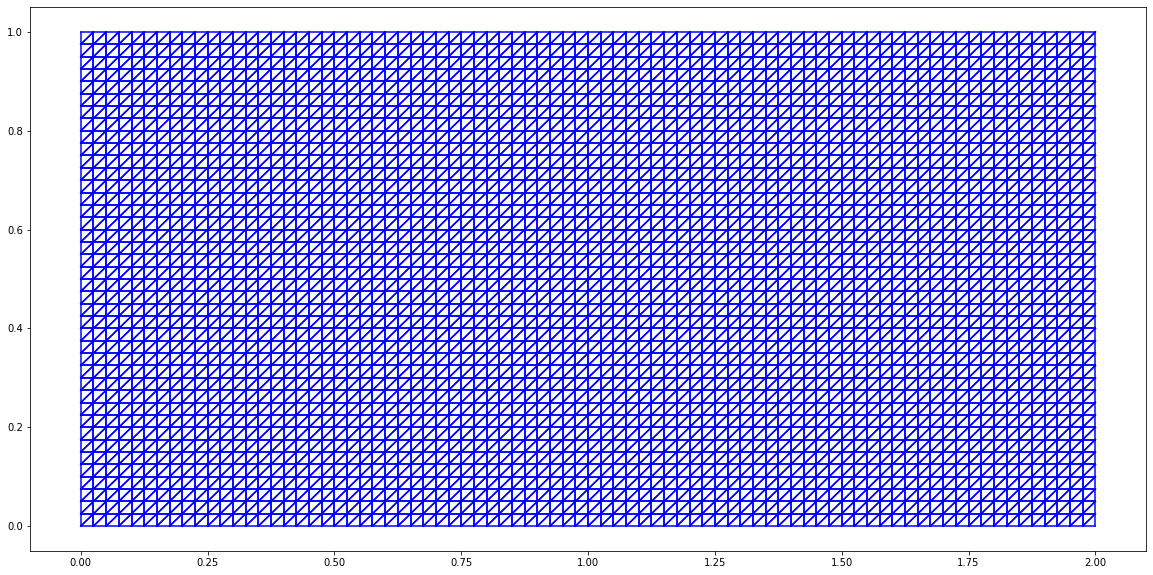

In [4]:
L,H=2,1
ndx,ndy=80,40
xyz,IEN,ID,LM  = MeshDomain(ndx, ndy, L, H)
Plot_Geometry (xyz, IEN, 'b')
#print(xyz,IEN,ID,LM)

Creamos función que nos permitirá resolver las integrales numericamente en el dominio isoparamétrico. En particular, esta función nos entrega los puntos de integración y pesos asociados.

In [5]:
def TriGaussQuad(k):
  if k == 1:
    xi = np.array([[1./3, 1./3]])
    w = np.array([1/2])
  
  elif k == 2:
    xi = np.array([[2/3,1/6],[1/6,1/6],[1/6,2/3]])
    w = np.array([1/6,1/6,1/6])

  return xi,w

Por ejemplo, consideremos un triángulo cuyos vértices son (1,0); (0,1); (0,0) (dominio isoparamétrico)  y graficamos los puntos de cuadratura para $k=2$


C:\Users\msday\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


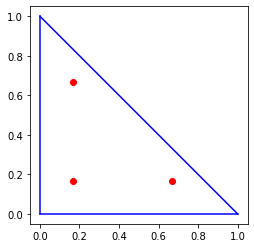

In [6]:
xi = np.array([2./3., 1./6.])

xil, wl = TriGaussQuad(2)

#%% ii)
xeset = np.array([[1.,0.,0.],
                   [0.,1.,0.]])


arr = [[0,1],[1,2],[2,0]]
coors = xeset.T
plt.figure()
for a in range(len(arr)):
    x = coors[arr[a],0]
    y = coors[arr[a],1]
    plt.plot(x, y,  color = 'b') 
plt.plot(xil.T[0,:],xil.T[1,:],'ro')
plt.axes().set_aspect('equal')
plt.show()
            

Creamos una función que nos permita obtener las funciones de forma y sus derivadas. Para ello, recordamos que estas pueden ser obtenidas a partir de las expresiones en el dominio isoparamétrico
 \begin{equation}
N_a^e(x)=\hat{N}_a(\hat{\xi}(x))
	\end{equation}


 \begin{equation}
\nabla_x N_a^e(x)=J^{-T} \nabla_\xi \hat{N}_a 
	\end{equation}

In [7]:
def P1shp(xeset,xi):
    xi1=xi[0]
    xi2=xi[1]
    xi3=1-xi1-xi2
    
    N1hat=xi1
    N2hat=xi2
    N3hat=xi3

    Nhat=np.matrix([N1hat,N2hat,N3hat])      
    DN11hat=1
    DN12hat=0

    DN21hat=0
    DN22hat=1
    DN31hat=-1
    DN32hat=-1
    
    DNhat=np.matrix([[DN11hat,DN21hat,DN31hat],
                     [DN12hat,DN22hat,DN32hat]])
    
    xhat=(Nhat*xeset.T)
    
    J=(xeset*DNhat.T)
    detJ=abs(np.linalg.det(J))   
    N=Nhat
    invJ = np.linalg.inv(J)
    DN=invJ.T*DNhat
    return xhat,N,DN,detJ

Para el problema de Poisson, la matriz de rigidez y el vector de fuerzas a nivel elemental pueden obtenerse transformando al dominio isoparamétrico e integrando numéricamente
    

 \begin{equation}
        {k}^e =\int_{{\Omega}^e} {B}^T {\kappa} B dx = \int_{\hat{\Omega}^e} {B}^T(\hat{{x}}(  {\xi})) {\kappa}{{B}}(\hat{ {x}}( {\xi})) \ |\text{det} {J} (\xi) | \text{d} \xi  \approx \sum^{Nq}_1   {B}^T(\hat{{x}}(  {\xi_q})) {\kappa}{{B}}(\hat{ {x}}( {\xi_q})) \ |\text{det} {J} (\xi_q) | \cdot w_q
	\end{equation}
    
    
  \begin{equation}
        {f}^e =\int_{{\Omega}^e} {N}^T {f} dx = \int_{\hat{\Omega}^e} {N}^T(\hat{{x}}(  {\xi})) f  \ |\text{det} {J} (\xi)  | \text{d} \xi \approx \sum^{Nq}_1   {N}^T(\hat{{x}}(  {\xi_q})) {{f}} \ |\text{det} {J} (\xi_q) | \cdot w_q
	\end{equation}
    
(f=-1 y ${\kappa}$ es la identidad) 

In [8]:
def Element_Poisson(xeset, kappa, f, k):
    xil,wl = TriGaussQuad(k)
    ke = np.zeros([3,3])
    fe = np.zeros([3,1])
    
    for l in np.arange(len(wl)):
        xi, w = xil[l], wl[l]
        xhat, N, B, detJ = P1shp(xeset,xi)
        
        ke = ke + w*(B.T*kappa*B)*detJ 
        fe = fe + w*(N.T*f)*detJ
       
    return ke, fe

Creamos una función que nos permita ensamblar las contribuciones elementales y obtener la matriz de rigidez y vector de fuerzas 
a nivel de modelo 

In [9]:
def Model_Poisson(xyz, ien, LM, kappa, f, k):
    nen = ien.shape[1]
    nel = ien.shape[0]
    ndofs = np.max(LM)+1
    K = np.asmatrix(np.zeros([ndofs,ndofs]))
    F = np.asmatrix(np.zeros([ndofs,1]))
    
    for e in np.arange(nel):
        xeset = np.asmatrix(xyz[ien[e]].T)
        ke,fe = Element_Poisson(xeset,kappa,f,k)  
        
        for a in np.arange(nen):
            A=LM[e,a]
            if A!=-1:
                for b in np.arange(nen):
                    B=LM[e,b]
                    if B!=-1:
                        K[A,B]=K[A,B]+ke[a,b]
                F[A]=F[A]+fe[a]    
                
    return K,F

Finalmente, resolvermos el problema y graficamos

C:\Users\msday\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


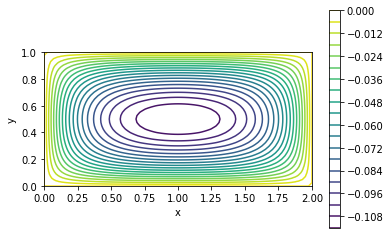

In [10]:
kappa = np.array([[1.,0.],[0.,1.]])
f = -1
k=2


K, F = Model_Poisson(xyz, IEN, LM, kappa, f, k)
T = np.linalg.solve(K,F)


Th = np.zeros(ID.shape[0])

for i in np.arange(Th.shape[0]):
    if ID[i] != -1:
        Th[i]=T[ID[i]]

plt.figure()
plt.tricontour(xyz[:,0],xyz[:,1],IEN,Th,20)
plt.xlim(0,L)
plt.ylim(0,H)            
plt.axes().set_aspect('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()        